<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/pedro/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *

In [3]:
dataset_path = '/content/gdrive/MyDrive/Capstone/Data/munich_data'

# define mask function

def mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = dataset_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)


In [5]:
# Create datablock
parks_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=mask_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

# Dataloaders with batch size 16

dls16 = parks_block.dataloaders(dataset_path, bs=4)

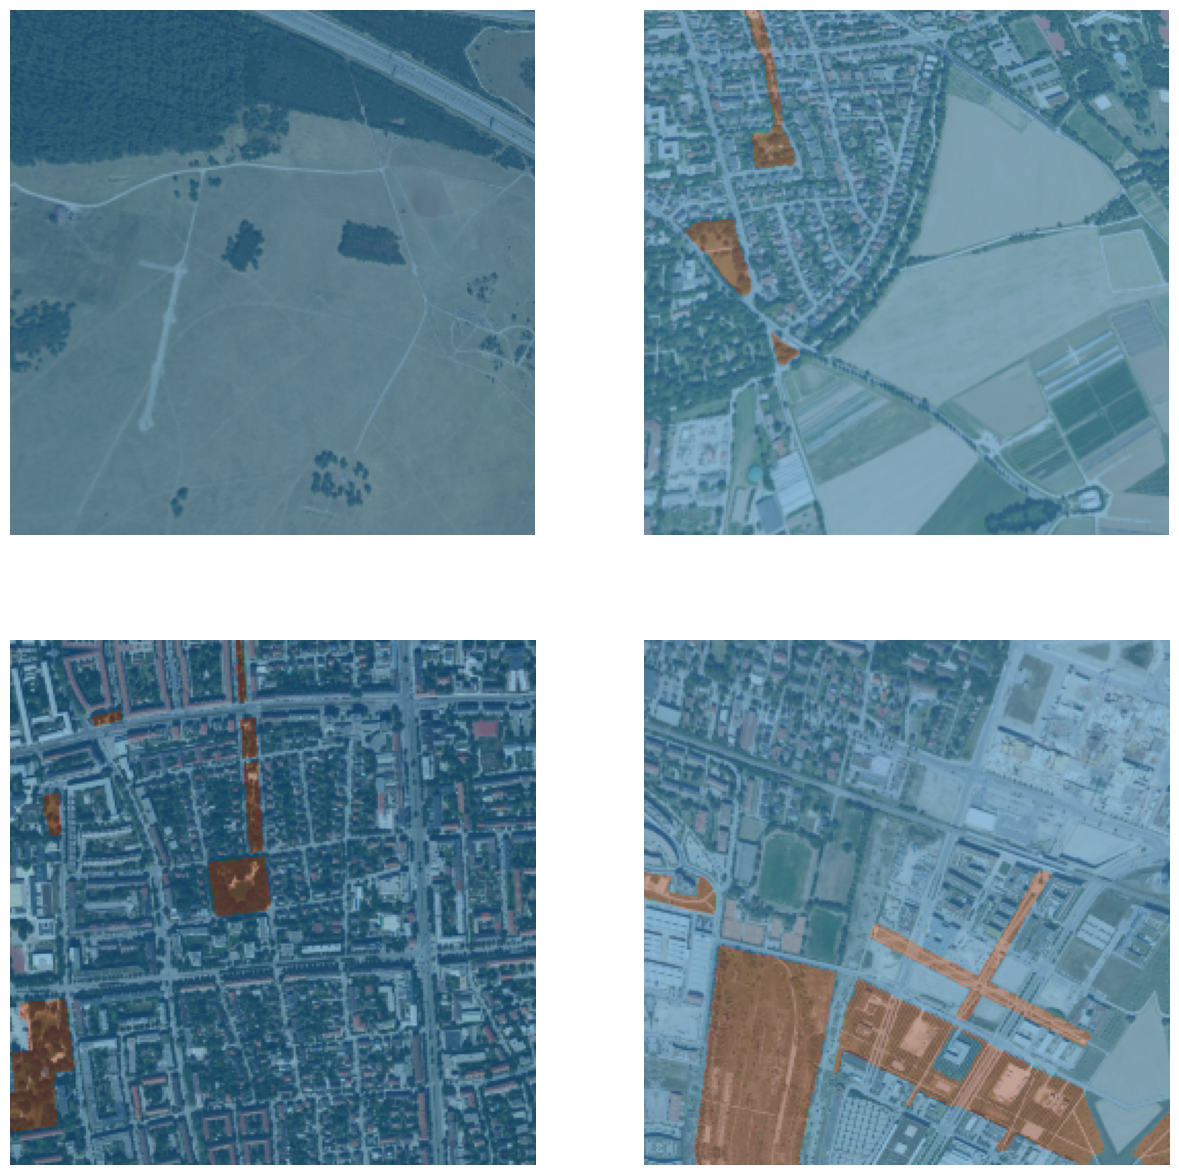

In [6]:
dls16.show_batch(figsize=(15, 15))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 92.2MB/s]


SuggestedLRs(valley=7.585775892948732e-05)

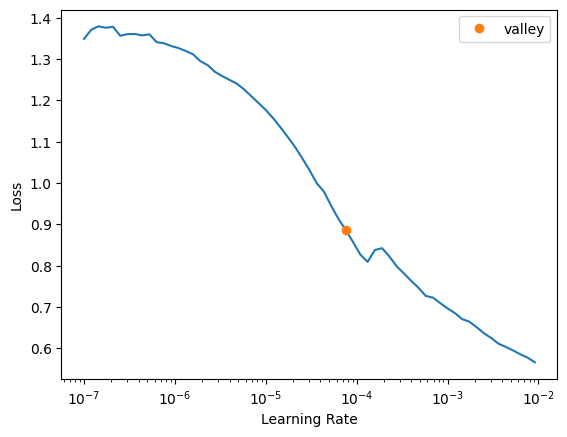

In [7]:
learn = unet_learner(dls16,resnet34,metrics=Dice)
learn.lr_find()

In [8]:
learn.fit_one_cycle(40, lr_max=7.585775892948732e-05, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_fr')])

epoch,train_loss,valid_loss,dice,time
0,0.461125,0.333705,0.003927,00:34
1,0.326943,0.270902,0.001338,00:24
2,0.291883,0.250041,0.000156,00:25
3,0.250098,0.244790,0.000050,00:23
4,0.251823,0.215422,0.000022,00:25
5,0.240147,0.223468,0.001370,00:24
6,0.233203,0.237894,0.060854,00:26
7,0.224636,0.192438,0.001909,00:24
8,0.225430,0.205106,0.224099,00:24
9,0.211536,0.209815,0.386282,00:25


Better model found at epoch 0 with dice value: 0.0039272382021017195.
Better model found at epoch 6 with dice value: 0.060853676170945566.
Better model found at epoch 8 with dice value: 0.22409873941253405.
Better model found at epoch 9 with dice value: 0.3862820336390071.
Better model found at epoch 15 with dice value: 0.45073770415695597.
Better model found at epoch 21 with dice value: 0.46877014015473173.
No improvement since epoch 21: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


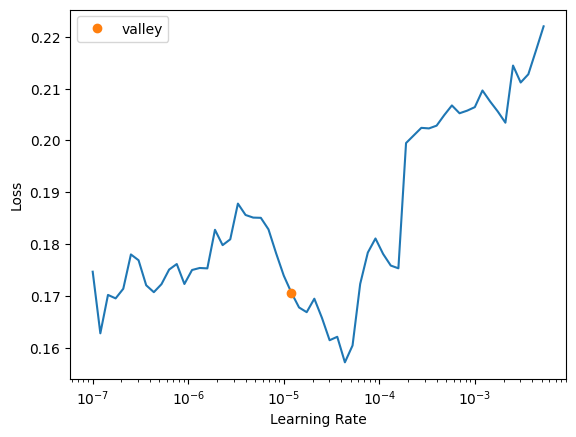

In [9]:
learn = learn.load('best_fr')
learn.unfreeze()
lr = learn.lr_find()

In [11]:
learn.fit_one_cycle(
    40, lr_max=slice(lr.valley/10,lr.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_model')]
         )



epoch,train_loss,valid_loss,dice,time
0,0.152044,0.193193,0.437876,00:25
1,0.151113,0.188169,0.425948,00:26
2,0.148948,0.193791,0.389311,00:24
3,0.144557,0.243094,0.366391,00:25
4,0.154512,0.172357,0.339964,00:27
5,0.145628,0.192375,0.400659,00:25
6,0.159819,0.181287,0.407616,00:25
7,0.144432,0.168518,0.412618,00:25
8,0.148178,0.203025,0.000173,00:25
9,0.154877,0.276753,0.305461,00:26


Better model found at epoch 0 with dice value: 0.4378761796627965.
Better model found at epoch 10 with dice value: 0.4509546075909882.
Better model found at epoch 15 with dice value: 0.5044374675533362.
Better model found at epoch 16 with dice value: 0.5164151614790062.
No improvement since epoch 16: early stopping


In [12]:
learn = learn.load("best_model")
print("in-sample performance: {}".format(np.array(learn.validate(ds_idx=0)[1])))

in-sample performance: 0.739146920084066


In [13]:
print("out-of-sample performance: {}".format(np.array(learn.validate(ds_idx=1)[1])))

out-of-sample performance: 0.5164151614790062
